## Hyperparameter Tuning
This Notebook is a part of the Thesis Project: Learning Multilingual Document Representations. (Marc Lenz, 2021)

-------------------------------------------------

**General Information**
- Inside this Notebook, different methods to create multilingual document representations are tested and evaluated. 

- Which methods, parameter-settings and languages are used for the evaluation can be adjusted by changing the variables in the Cell below. 

- This Notebook was run in Google Colab. 

**About the Methods and Datasets**

Datasets: 
 - JRC-Arquis (sample of 5000 Documents)
 - EU-Bookshop (sample of ~9000 Documents, first 5000 are selected)

Methods:

- Methods which are based on creating mappings between monolingual corpora.
Those methods are: Linear Concept Approximation (LCA), Linear Concept Compression(LCC) and the Neural Network versions of those: NNCA and NNCC. 
For them, first the monolingual representation have to be created, then the mapping can be applied. Algorithms which are applied here to derive monolingual representations are: Latent Semantic indexing and Doc2Vec (Mikolov et al.)

- Methods which derive multilingual representations directly. Those are: Cross-Lingual Latent Semantic Indexing (CL-LSI) and the improved version of it, which is also described within the theoretical section of the Thesis. 

In [21]:
"""
----
Languages Preprocessed for JRC_Arquis: en, hu, fr, de, nl, pt, cz, pl
Languages Preprocessed for EU-Bookshop: en, es, fr

"""
#Choose either "JRC_Arquis" "EU-Bookshop"
dataset = "JRC_Arquis" 

#Determines which methods are tested
# True -> Method is evaluated
# False -> Method is ignored
test_LCA = True
test_LCC = True
test_CLLSI = True
test_neural_networks = False

#Set languages, dimensions and kind of monolingual embedding
#The monolingual embedding method influences the results of 
# LCA, LCC, NNCA, and NNCC
languages = ["en", "fr", "hu"]
dimensions = [200, 400, 800]
embedding_method = "Doc2Vec"

#If any other dimensions should be tested for certain models, specify here
lca_dimensions = dimensions
lcao_dimensions = dimensions
lcc_dimensions = dimensions
cllsi_dimensions = dimensions
nn_dimensions = dimensions


##  Load Dataset
- First of all, clone the git repository which contains most of the functions and models for this Notebook

In [1]:
!git clone https://github.com/marc-lenz/thesis_code.git

fatal: destination path 'thesis_code' already exists and is not an empty directory.


- then load the Dataset

In [3]:
from google.colab import drive
import pandas as pd 
import numpy as np
import pickle

drive.mount("/content/gdrive")

if dataset == "JRC_Arquis" :
  main_dir = "/content/gdrive/My Drive/Thesis/JRC_Arquis_files/"
  sample_df = pd.read_pickle(main_dir+"sample_df_preprocessed.pkl")
  train_df = sample_df[:3000]
  val_df = sample_df[3000:4000]
  test_df = sample_df[4000:5000]
  
elif dataset == "EU-Bookshop": 
  main_dir = "/content/gdrive/My Drive/Thesis/EU-BookShop Files/"
  #define

  def get_eub_dataframe(main_dir):
    def load(filepath):
      with open(filepath,"rb") as f:
          obj = pickle.load(f)
      return obj
    tokenized_en = load(main_dir+"/tokenized_en.list")
    tokenized_fr = load(main_dir+"/tokenized_fr.list")
    tokenized_es = load(main_dir+"/tokenized_es.list")
    sample_df = pd.DataFrame()
    sample_df["body_pre_en"] = tokenized_en
    sample_df["body_pre_fr"] = tokenized_fr
    sample_df["body_pre_es"] = tokenized_es
    #erase empty lists
    for key in sample_df.keys():
      sample_df = sample_df[sample_df.astype(str)[key] != '[]']
    return sample_df

  sample_df = get_eub_dataframe(main_dir)[:5000]
  train_df = sample_df[:3000]
  val_df = sample_df[3000:4000]
  test_df = sample_df[4000:5000]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
sample_df

,number,body_de,lang_de,body_en,lang_en,body_nl,lang_nl,body_pl,lang_pl,body_hu,lang_hu,body_cs,lang_cs,body_fr,lang_fr,body_pt,lang_pt,body_pre_hu,body_pre_fr,body_pre_en,body_pre_de,body_pre_nl,body_pre_pl,body_pre_cs,body_pre_pt
16307,31981D0691,\n \n 81/691/EWG: Beschluß des Rates v...,de,\n \n 81/691/EEC: Council Decision of ...,en,\n \n 81/691/EEG: Besluit van de Raad ...,nl,\n \n \n Decyzja Rady\n ...,pl,\n \n \n A Tanács határozata\n ...,hu,\n \n \n Rozhodnutí Rady\n ...,cs,"\n \n 81/691/CEE: Décision du Conseil,...",fr,"\n \n 81/691/CEE: Decisão do Conselho,...",pt,"[tan, cs, hat, rozat, szeptember, az, antarkti...","[ce, cision, du, conseil, du, septembr, concer...","[eec, council, decision, of, september, on, th...","[ewg, beschlu, des, rates, vom, september, ber...","[eeg, besluit, van, de, raad, van, september, ...","[decyzja, rady, dnia, wrze, nia, sprawie, zawa...","[rozhodnut, rady, ze, dne, uzav, en, mluvy, za...","[cee, decis, do, conselho, de, de, setembro, d..."
9669,52006XC0125(01),\n \n Bekanntmachung %uuml%ber die Ein...,de,\n \n Notice of initiation of an expir...,en,\n \n Inleiding van een herzieningspro...,nl,\n \n Zawiadomienie o wszczęciu przegl...,pl,\n \n %Eacute%rtes%iacute%t%eacute%s a...,hu,\n \n Oznámení o zahájení přezkumu pře...,cs,\n \n Avis d'ouverture d'un r%eacute%e...,fr,\n \n Aviso de in%iacute%cio de um ree...,pt,"[eacut, rtes, iacut, eacut, az, ukraj, aacut, ...","[avis, ouvertur, un, eacut, examen, au, titr, ...","[notice, of, initiation, of, an, expiry, revie...","[bekanntmachung, uuml, ber, die, einleitung, e...","[inleiding, van, een, herzieningsprocedure, bi...","[zawiadomienie, wszcz, ciu, przegl, du, wyga, ...","[ozn, men, zah, jen, ezkumu, ed, pozbyt, platn...","[aviso, de, in, iacute, cio, de, um, reexame, ..."
2189,52005DC0670,\n \n Mitteilung der Kommission an den...,de,\n \n Communication from the Commissio...,en,\n \n Mededeling van de Commissie aan ...,nl,"\n \n Komunikat Komisji do Rady, Parla...",pl,\n \n A Bizotts%aacute%g k%ouml%zlem%e...,hu,"\n \n Sdělení Komise Radě, Evropskému ...",cs,\n \n Communication de la Commission a...,fr,\n \n Comunica%ccedil%%atilde%o da Com...,pt,"[bizotts, aacut, ouml, zlem, eacut, nye, tan, ...","[commun, de, la, commiss, au, conseil, au, par...","[communication, from, the, commission, to, the...","[mitteilung, der, kommission, an, den, rat, da...","[mededeling, van, de, commissie, aan, de, raad...","[komunikat, komisji, do, rady, parlamentu, eur...","[sd, len, komise, rad, evropsk, mu, parlamentu...","[comunica, ccedil, atilde, da, comiss, atilde,..."
13484,31998R0624,\n \n Verordnung (EG) Nr. 624/98 der K...,de,\n \n Commission Regulation (EC) No 62...,en,\n \n Verordening (EG) nr. 624/98 van ...,nl,\n \n \n Rozporządzenie Komisji...,pl,\n \n \n A Bizottság 624/98/EK ...,hu,\n \n \n Nařízení Komise (ES) č...,cs,\n \n Règlement (CE) n° 624/98 de la C...,fr,\n \n Regulamento (CE) nº 624/98 da Co...,pt,"[bizotts, ek, rendelet, rcius, cu, gazat, mela...","[glement, ce, de, la, commiss, du, mar, modifi...","[commission, regulation, ec, no, of, march, am...","[verordnung, eg, nr, der, kommission, vom, rz,...","[verordening, eg, nr, van, de, commissie, van,...","[rozporz, dzenie, komisji, we, nr, dnia, marca...","[na, zen, komise, es, ze, dne, ezna, kter, se,...","[regulamento, ce, da, comiss, de, de, mar, de,..."
7387,42000A0922(07),\n \n Schengen-Besitzstand - Übereinko...,de,\n \n The Schengen acquis - Agreement ...,en,\n \n Het Schengenacquis - Overeenkoms...,nl,\n \n \n Umowa o przystąpieniu ...,pl,\n \n \n Megállapodás az osztrá...,hu,\n \n \n Dohoda o přistoupení R...,cs,\n \n Acquis de Schengen - Accord d'ad...,fr,\n \n Acervo de Schengen - Acordo de A...,pt,"[meg, llap, az, osztr, zt, rsas, csatlakoz, be...","[acquis, de, schengen, accord, adh, sion, de, ...","[the, schengen, acquis, agreement, on, the, ac...","[schengen, besitzstand, bereinkommen, ber, den...","[het, schengenacquis, overeenkomst, betreffend...","[umowa, przyst, p

## Choose Hyperparameter options and Train LSI
- > Define the languages and dimensions which should be tested here

In [29]:
from thesis_code.Utils import read_docs, Vector_Lsi_Model
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm 

max_dim = max(dimensions)
matrices = dict()


if embedding_method == "LSI":
  lsi_models = dict()
  for t in languages:
    key = "body_pre_{}".format(t)
    lsi_models[t] = Vector_Lsi_Model(sample_df[key], dimension=max_dim)
    matrices["{}_train_vecs".format(t)] = np.asarray(lsi_models[t].create_embeddings(train_df[key]))
    matrices["{}_test_vecs".format(t)] = np.asarray(lsi_models[t].create_embeddings(test_df[key]))

elif embedding_method =="Doc2Vec":
  for dimension in dimensions:
    matrices[dimension] = dict()
    for t in tqdm(languages):
      key = "body_pre_{}".format(t)
      #create tagged docs first
      documents = []
      for ind in sample_df.index:
        doc = sample_df["body_pre_en"][ind]
        tagged_doc = TaggedDocument(doc, [ind])
        documents.append(tagged_doc)
      #Train Doc2Vec Model
      model = Doc2Vec(documents, vector_size=dimension, window=20, min_count=1, workers=4)
      training_docs = [model[i] for i in train_df.index]
      validation_docs = [model[i] for i in val_df.index]
      test_docs = [model[i] for i in test_df.index]
      #set matrices
      matrices[dimension]["{}_train_vecs".format(t)] = np.asarray(training_docs)
      matrices[dimension]["{}_val_vecs".format(t)] = np.asarray(validation_docs)
      matrices[dimension]["{}_test_vecs".format(t)] = np.asarray(test_docs)



  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [01:18<02:37, 78.73s/it]

 67%|██████▋   | 2/3 [02:38<01:19, 79.11s/it]

100%|██████████| 3/3 [03:57<00:00, 79.33s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [01:44<03:28, 104.05s/it]

 67%|██████▋   | 2/3 [03:25<01:43, 103.20s/it]

100%|██████████| 3/3 [05:09<00:00, 103.07s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [02:17<04:35, 137.57s/it]

 67%|██████▋   | 2/3 [04:36<02:17, 138.00s/it]

100%|██████████| 3/3 [06:53<00:00, 137.94s/it]


In [23]:
from itertools import permutations
pairs = permutations(languages, 2)
pair_list = [p for p in pairs]

## Linear Concept Approximation

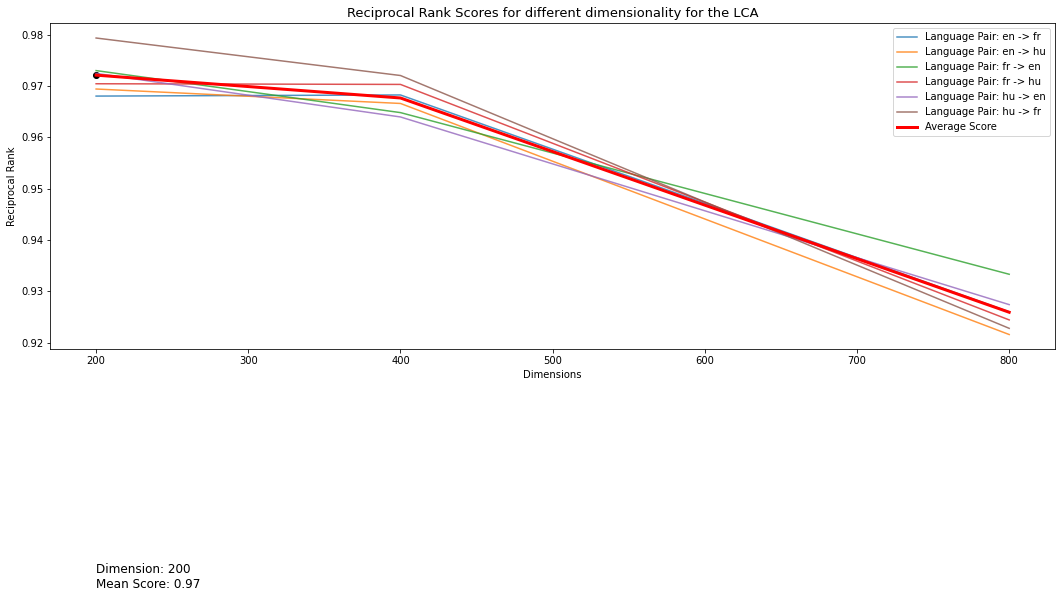

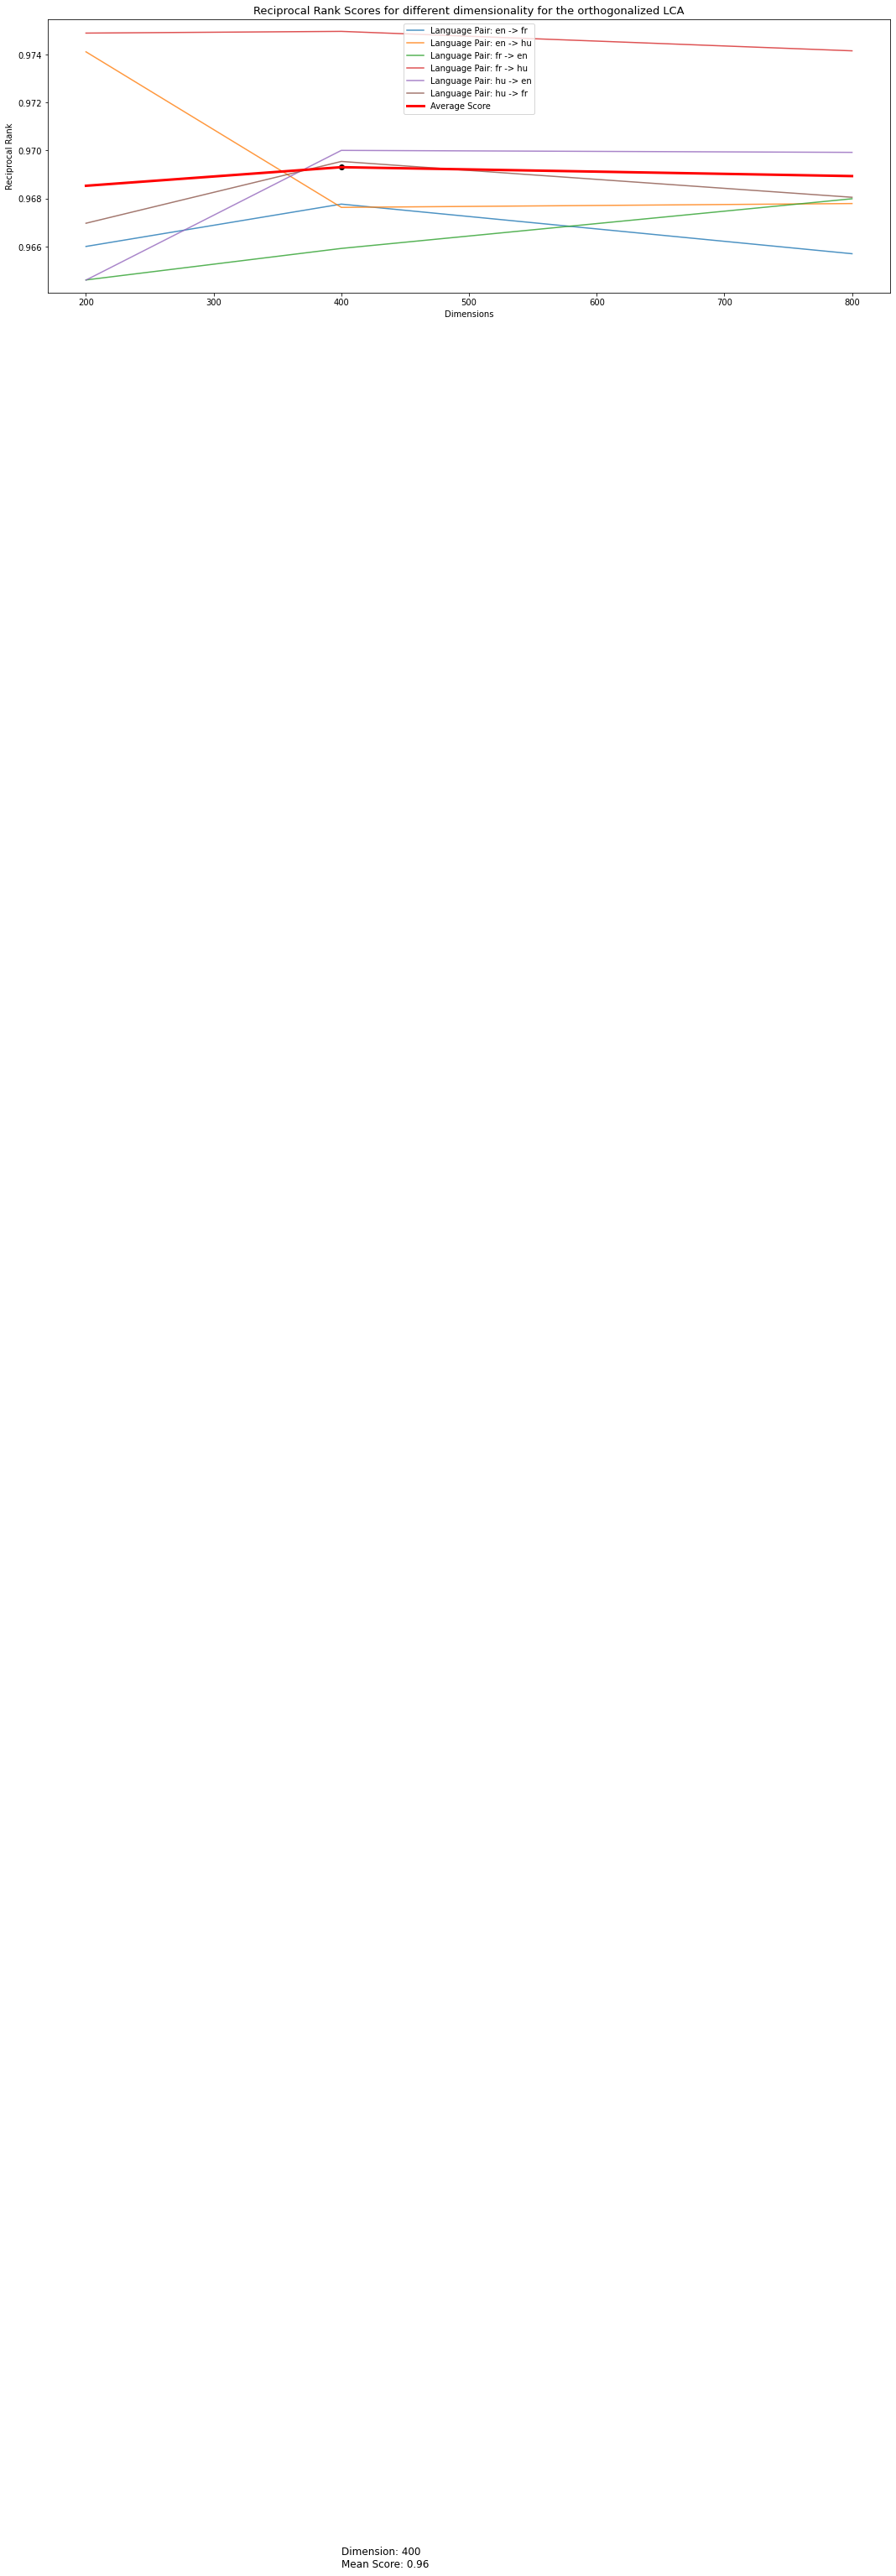

In [46]:
from thesis_code.evaluation_functions import evaluate_baseline_lca_model, evaluate_baseline_lca_model_ort
from thesis_code.evaluation_functions import mate_retrieval, reciprocal_rank
from tqdm import tqdm

if test_LCA == True:
  lca_scores = []
  lcao_scores = []

  for pair in pair_list:
    l1 = pair[0]
    l2 = pair[1]
    if embedding_method == "LSI":
      l1_train, l1_test = matrices["{}_train_vecs".format(l1)], matrices["{}_val_vecs".format(l1)]
      l2_train, l2_test = matrices["{}_train_vecs".format(l2)], matrices["{}_val_vecs".format(l2)]
      score_lca = evaluate_baseline_lca_model(l1_train, l1_test, l2_train, l2_test, dimensions, reciprocal_rank)
      score_lcao = evaluate_baseline_lca_model_ort(l1_train, l1_test, l2_train, l2_test, dimensions, reciprocal_rank)
    if embedding_method =="Doc2Vec":
      score_lca = []
      score_lcao = []
      for dimension in dimensions: 
        l1_train, l1_test = matrices[dimension]["{}_train_vecs".format(l1)], matrices[dimension]["{}_val_vecs".format(l1)]
        l2_train, l2_test = matrices[dimension]["{}_train_vecs".format(l2)], matrices[dimension]["{}_val_vecs".format(l2)]
        score_lca.append(evaluate_baseline_lca_model(l1_train, l1_test, l2_train, l2_test, [dimension], reciprocal_rank)[0])
        score_lcao.append(evaluate_baseline_lca_model_ort(l1_train, l1_test, l2_train, l2_test, [dimension], reciprocal_rank)[0])


    lca_scores.append(score_lca)
    lcao_scores.append(score_lcao )

  from thesis_code.evaluation_functions  import plot_parameter_graph
  title_lca = "Reciprocal Rank Scores for different dimensionality for the LCA"
  title_lcao = "Reciprocal Rank Scores for different dimensionality for the orthogonalized LCA"

  plot_parameter_graph(dimensions, lca_scores, title = title_lca, pair_list=pair_list)
  plot_parameter_graph(dimensions, lcao_scores, title = title_lcao, pair_list=pair_list)

In [28]:
matrices[200]["fr_val_vecs"].shape

(1000, 800)

##LCC Scores



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:12<00:00, 12.35s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:12<00:00, 12.37s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:12<00:00, 12.24s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


  0%|          | 0/1 [00:00<?, ?it/s]

10

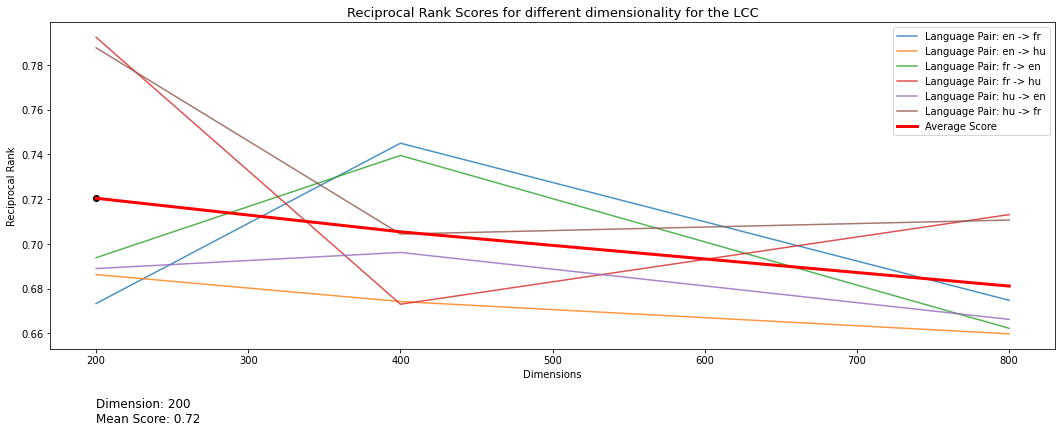

In [31]:
from thesis_code.evaluation_functions import evaluate_lcc_model

if test_LCC == True:
  lcc_scores = []

  for pair in pair_list:
    l1 = pair[0]
    l2 = pair[1]
    if embedding_method =="LSI":
      l1_train, l1_test = matrices["{}_train_vecs".format(l1)], matrices["{}_test_vecs".format(l1)]
      l2_train, l2_test = matrices["{}_train_vecs".format(l2)], matrices["{}_test_vecs".format(l2)]
      score_lcc = evaluate_lcc_model(l1_train, l1_test, l2_train, l2_test, dimensions, evaluation_function = reciprocal_rank)
      lcc_scores.append(score_lcc)
    if embedding_method =="Doc2Vec":
      score_lcc = []
      for dimension in dimensions: 
        l1_train, l1_test = matrices[dimension]["{}_train_vecs".format(l1)], matrices[dimension]["{}_val_vecs".format(l1)]
        l2_train, l2_test = matrices[dimension]["{}_train_vecs".format(l2)], matrices[dimension]["{}_val_vecs".format(l2)]
        score_lcc.append(evaluate_lcc_model(l1_train, l1_test, l2_train, l2_test, [dimension], reciprocal_rank)[0])
    lcc_scores.append(score_lcc)

  title_lcc = "Reciprocal Rank Scores for different dimensionality for the LCC"
  plot_parameter_graph(dimensions, lcc_scores, title = title_lcc, pair_list=pair_list)

#Cross-Lingual LSI

In [ ]:
from thesis_code.evaluation_functions import evaluate_cllsi, evaluate_improved_cllsi
from tqdm import tqdm
if test_CLLSI == True:
  cllsi_scores = []
  i_cllsi_scores = []

  for pair in tqdm(pair_list):
    l1 = pair[0]
    l2 = pair[1]
    l1_train, l1_test = list(train_df["body_pre_{}".format(l1)]), list(val_df["body_pre_{}".format(l1)])
    l2_train, l2_test = list(train_df["body_pre_{}".format(l2)]), list(val_df["body_pre_{}".format(l2)])
    cllsi_score = evaluate_cllsi(l1_train, l1_test, l2_train, l2_test, dimensions, evaluation_function = reciprocal_rank)
    print("pair: {}, CL-LSI score: {}".format(pair, cllsi_score) )
    i_cllsi_score = evaluate_improved_cllsi(l1_train, l1_test, l2_train, l2_test, dimensions, evaluation_function = reciprocal_rank)
    print("pair: {}, CL-LSI score: {}".format(pair, i_cllsi_score))
    cllsi_scores.append(cllsi_score)
    i_cllsi_scores.append(i_cllsi_score)

  title_cllsi = "Reciprocal Rank Scores for different dimensionality for the CL-LSI"
  title_i_cllsi = "Reciprocal Rank Scores for different dimensionality for the improved CL-LSI "
  plot_parameter_graph(dimensions, cllsi_scores, title = title_cllsi, pair_list=pair_list)
  plot_parameter_graph(dimensions, i_cllsi_scores, title = title_i_cllsi)




  0%|          | 0/6 [00:00<?, ?it/s]

##Neural Networks 

Test Neural Networks here

In [ ]:
from thesis_code.evaluation_functions import evaluate_single_layer_lca_nn, evaluate_lcnn

In [ ]:
if test_neural_networks == True:
  lcnn_scores = []
  lca_nn_scores = []

  for pair in pair_list:
    l1 = pair[0]
    l2 = pair[1]
    l1_train, l1_test = matrices["{}_train_vecs".format(l1)], matrices["{}_test_vecs".format(l1)]
    l2_train, l2_test = matrices["{}_train_vecs".format(l2)], matrices["{}_test_vecs".format(l2)]

    lcnn_score = evaluate_lcnn(l1_train, l1_test, l2_train, l2_test, evaluation_function = reciprocal_rank)
    lcnn_scores.append(lcnn_score)
    lca_nn_score = evaluate_single_layer_lca_nn(l1_train, l1_test, l2_train, l2_test, evaluation_function = reciprocal_rank)
    lca_nn_scores.append(lca_nn_score)

In [ ]:
avg_scores = np.mean(lcnn_scores, axis=0)
print(np.where(avg_scores == np.max(avg_scores)))
print(np.max(avg_scores))

In [ ]:
rp_score 